Aim
---
To investigate the map errors induced by altering the power law index of the GSMA.

In [1]:
import src.sky_models as SM
from anstey.generate import gen_err_gsma
import numpy as np
from scipy.special import erf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import healpy as hp
import seaborn as sns

In [2]:
T230 = SM.foreground_gsma_nsidelo(nu=230)
TCMB = SM.T_CMB

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Want to see how relevant the CMB contribution to the following formula is:
$$
\frac{\Delta \mathbf{T}_{230}}{\mathbf{T}_{230}} = \left[\left(\frac{408}{230}\right)^{\boldsymbol{\delta}}-1\right]\left(1 - \frac{T_\mathrm{CMB}}{\mathbf{T}_{230}}\right)
$$

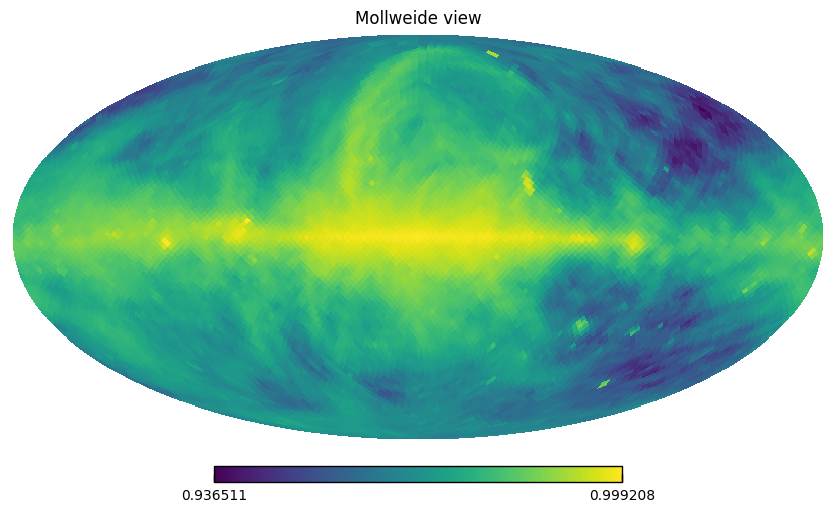

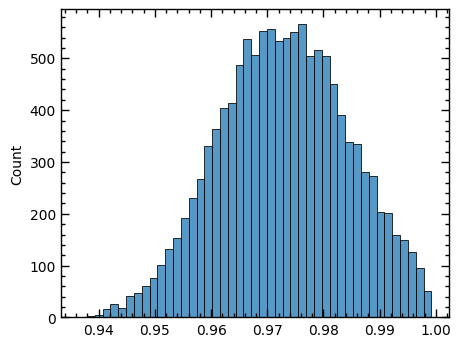

In [3]:
hp.mollview(1-TCMB/T230)
plt.show()
sns.histplot(1-TCMB/T230)
plt.show()

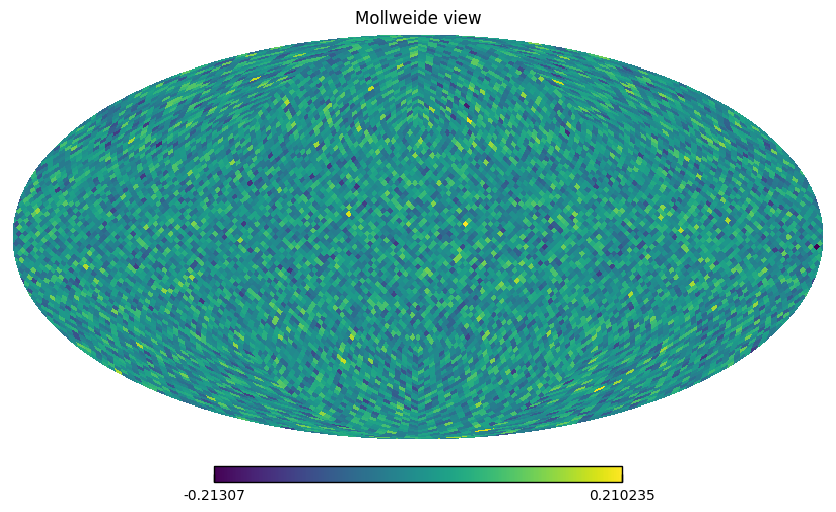

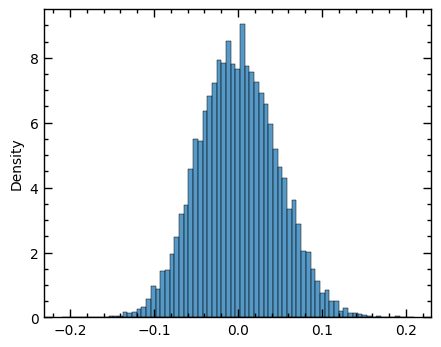

In [4]:
percent_err = 5
delta_vec = np.random.normal(scale=SM.basemap_err_to_delta(percent_err), size=np.shape(T230))
hp.mollview((408/230)**delta_vec - 1)
plt.show()
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.show()

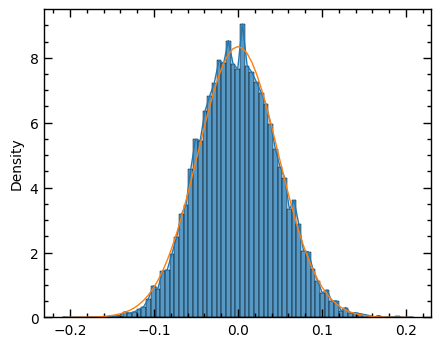

Gauss width = 0.047808788574558655
chi-sq = 2.2082488520811894


In [5]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x)**2/sig**2)
res = curve_fit(f, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
np.sqrt(res[1])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

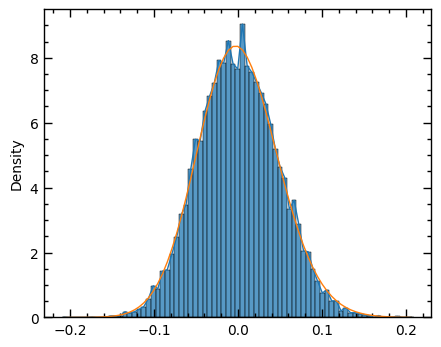

Gauss width = 0.05862138135608361
Gauss skew = 1.0283975173750568
Gauss mean = -0.032905989076299894
Cov =  [[ 4.03257331e-06  2.61766920e-04 -5.42849790e-06]
 [ 2.61766920e-04  1.78458589e-02 -3.63758346e-04]
 [-5.42849790e-06 -3.63758346e-04  7.64845903e-06]]
chi-sq = 2.35622723032716


In [6]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

def skew_gauss(x, sig, sk, mu):
    gaussian = 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x-mu)**2/sig**2)
    return gaussian * (1 + erf(sk*(x-mu)/(np.sqrt(2)*sig)))

res = curve_fit(skew_gauss, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, skew_gauss(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
print("Gauss skew =", res[0][1])
print("Gauss mean =", res[0][2])
print("Cov = ", res[1])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-skew_gauss(xx,*res[0]))**2/skew_gauss(xx,*res[0]))
print("chi-sq =", chi_sq)

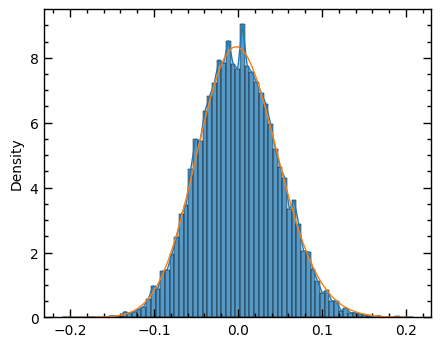

Gauss width = 0.0478426605171357
chi-sq = 3.822438575365731


In [7]:
p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
n, bins = np.histogram(p_vec, bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)

f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)*np.abs(1+x)) * np.exp(-0.5*np.log(x+1)**2/sig**2)
res = curve_fit(f, xx, n)
sns.histplot(((408/230)**delta_vec - 1)*(1-TCMB/T230), bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])
np.sqrt(res[1])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

In [8]:
# Package the above into functions to find the skew as a function of delta.
def find_width_skewgauss(deltas):
    """
    Finds the width if the distribution is modelled as a skewed gaussian.
    """
    def skew_gauss(x, sig, sk, mu):
        gaussian = 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x-mu)**2/sig**2)
        return gaussian * (1 + erf(sk*(x-mu)/(np.sqrt(2)*sig)))
    widths=[]
    for delta in deltas:
        delta_vec = np.random.normal(scale=delta, size=np.shape(T230))
        p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
        
        n, bins = np.histogram(p_vec, bins=75, density=True)
        xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
        xx = np.array(xx)
        
        res = curve_fit(skew_gauss, xx, n)
        widths.append(res[0][0])
    return widths

def find_width_special(deltas):
    """
    Uses the special actual pdf to find the width.
    """
    f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)*np.abs(1+x)) * np.exp(-0.5*np.log(x+1)**2/sig**2)
    widths=[]
    for delta in deltas:
        delta_vec = np.random.normal(scale=delta, size=np.shape(T230))
        p_vec = ((408/230)**delta_vec - 1)*(1-TCMB/T230)
        n, bins = np.histogram(p_vec, bins=75, density=True)
        xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
        xx = np.array(xx)
        
        res = curve_fit(f, xx, n)
        widths.append(res[0][0])
    return widths

In [9]:
SM.basemap_err_to_delta(20)

0.31808342041743537

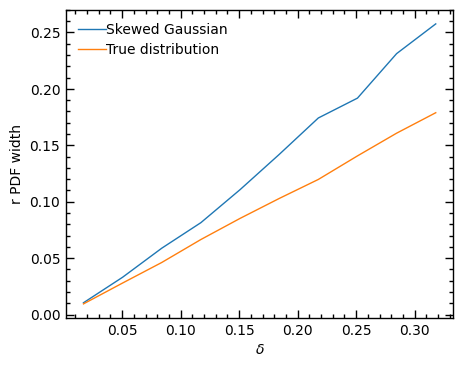

In [10]:
deltas = np.linspace(0.017,0.318, 10)
widths_skg = find_width_skewgauss(deltas)
widths_spc = find_width_special(deltas)
plt.plot(deltas, widths_skg, label='Skewed Gaussian')
plt.plot(deltas, widths_spc, label='True distribution')
plt.xlabel(r"$\delta$")
plt.ylabel(r"r PDF width")
plt.legend()

## Test new GSMA error generation


In [11]:
delta = 0.05

# Generate the fiducial GSMA map at 50, 230 and 408 MHz.
_, fid_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True)
# Generate the GSMA map with basemap errors of 5% at the same frequencies
# on the T_230 basemap only.
_, bm1_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True, delta=delta, err_type='bm1', seed=124)
# on both T_230 and T_408 basemaps.
_, bm2_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True, delta=delta, err_type='bm2', seed=124)


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


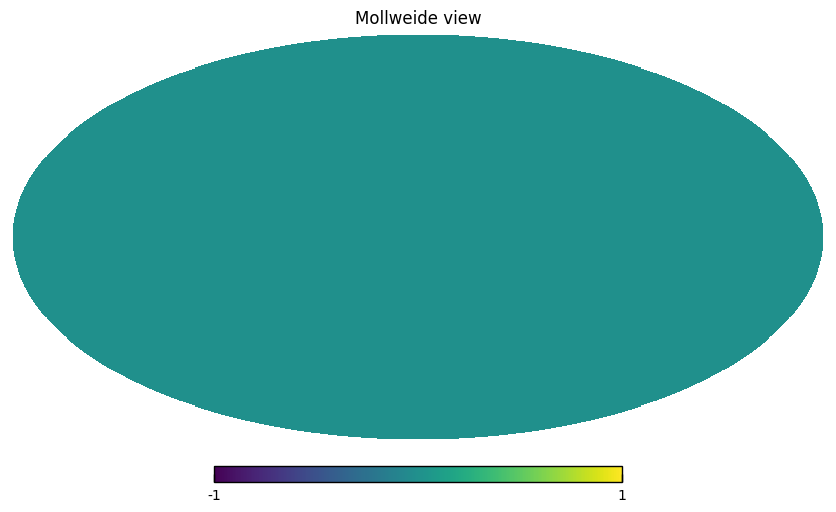

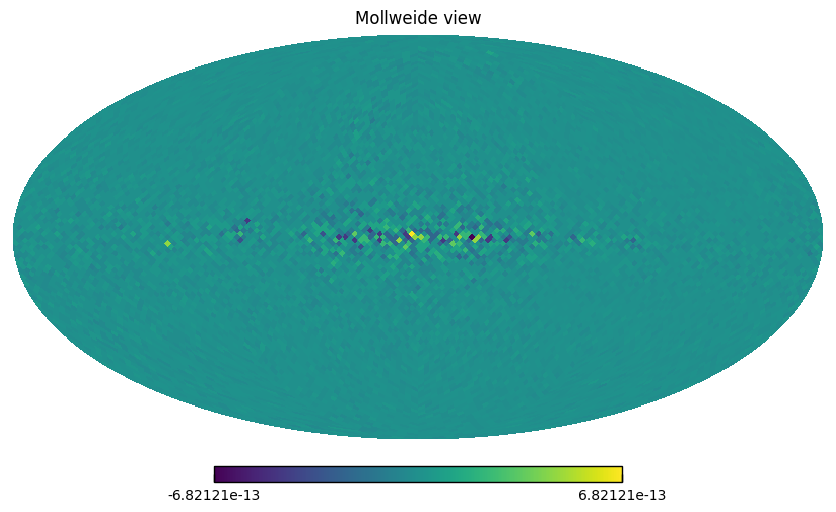

In [12]:
# Test the null cases: where we expect the maps to match.
# Fiducial T_408 vs the error case where only T_230 changes, evaluated at 408 MHz:
hp.mollview(fid_maps[2]-bm1_maps[2])
plt.show()
# The case where only T_230 changes vs the case where both change, evaluated at 230 MHz WITH THE SAME ERROR SEED:
hp.mollview(bm1_maps[1]-bm2_maps[1])
plt.show()

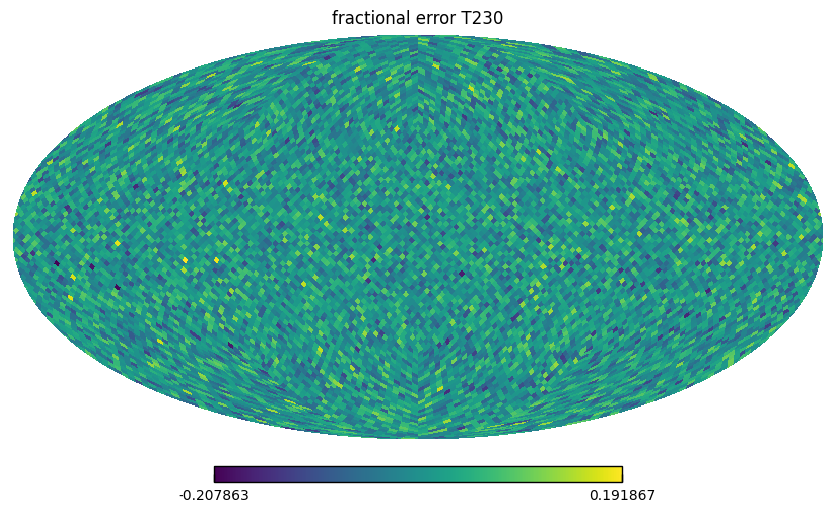

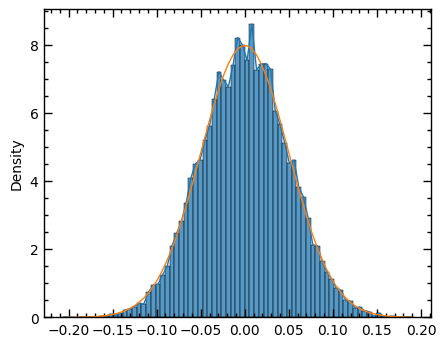

Gauss width = 0.049865924297637546
chi-sq = 1.0239233990807448


In [13]:
# Test the fractional error distributions.
# Fiducial T230 vs error T230 (both error cases produce the same T230 - see above)
hp.mollview((fid_maps[1]-bm1_maps[1])/fid_maps[1], title="fractional error T230")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[1]-bm1_maps[1])/fid_maps[1], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[1]-bm1_maps[1])/fid_maps[1], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

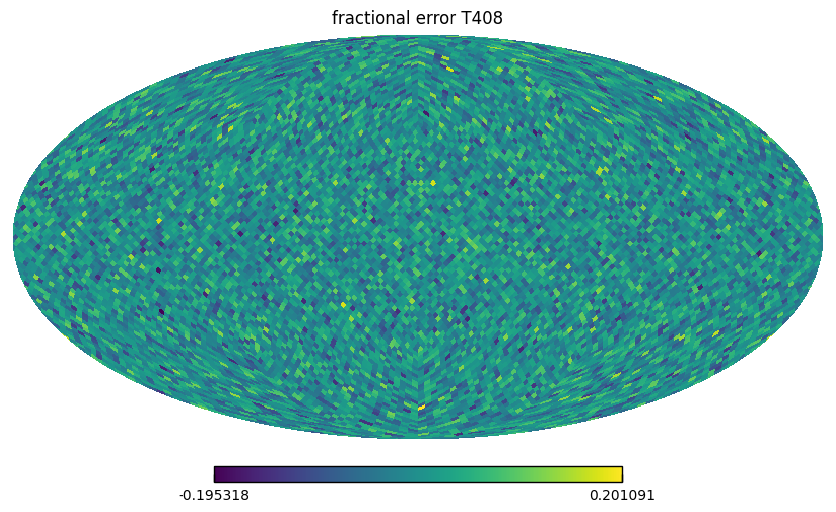

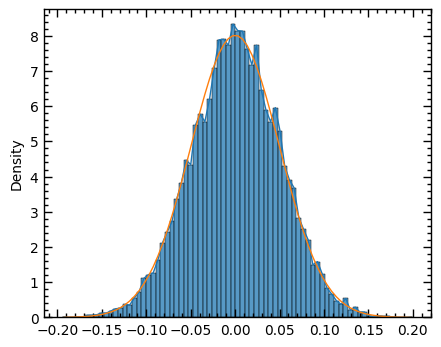

Gauss width = 0.04979367274912187
chi-sq = 1.2099343183290827


In [14]:
# Fiducial T408 vs error T408
hp.mollview((fid_maps[2]-bm2_maps[2])/fid_maps[2], title="fractional error T408")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[2]-bm2_maps[2])/fid_maps[2], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[2]-bm2_maps[2])/fid_maps[2], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

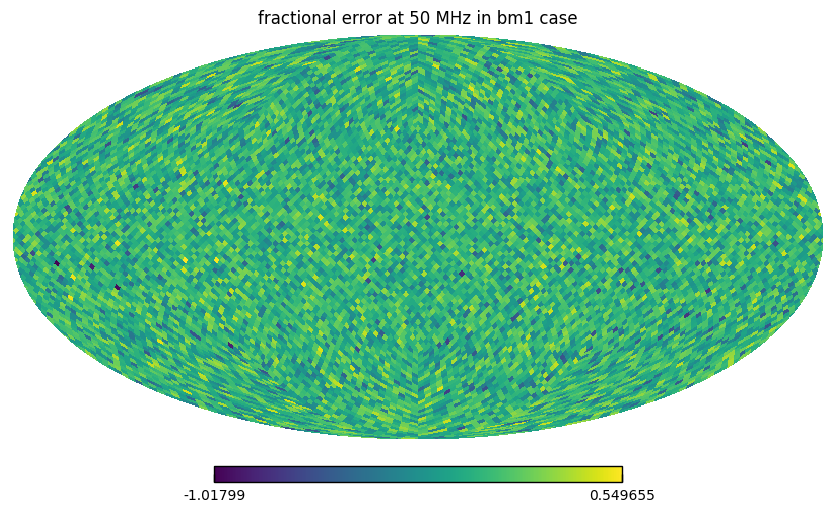

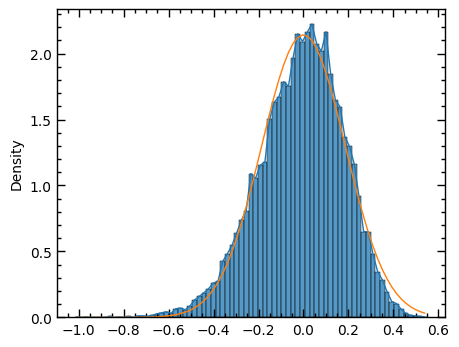

Gauss width = 0.18630433415497297
chi-sq = 23.876059733396474


In [15]:
# Finally, compare the fractional errors of the three maps at 50 MHz.
# First, fiducial vs error generated by varying T230 only:
hp.mollview((fid_maps[0]-bm1_maps[0])/fid_maps[0], title="fractional error at 50 MHz in bm1 case")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[0]-bm1_maps[0])/fid_maps[0], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[0]-bm1_maps[0])/fid_maps[0], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

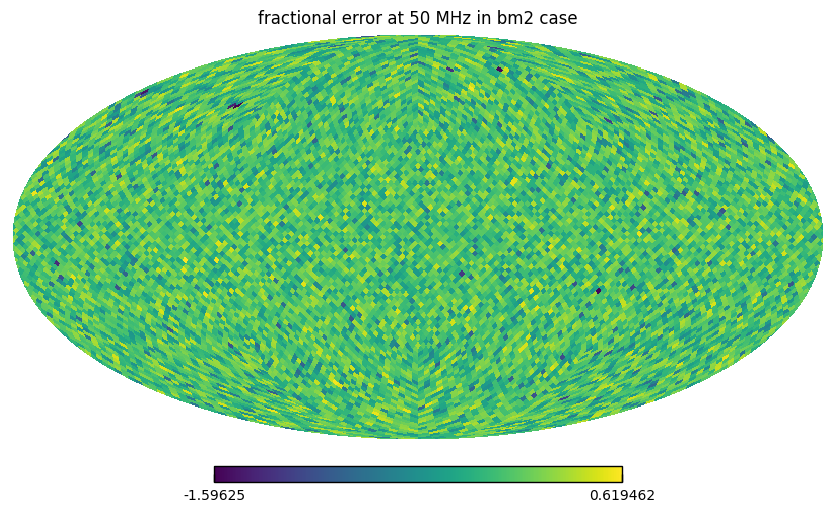

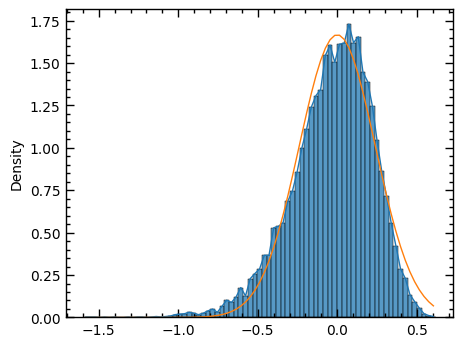

Gauss width = 0.23928540091851389
chi-sq = 23687.129520368027


In [16]:
# Finally, compare the fractional errors of the three maps at 50 MHz.
# First, fiducial vs error generated by varying T230 only:
hp.mollview((fid_maps[0]-bm2_maps[0])/fid_maps[0], title="fractional error at 50 MHz in bm2 case")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[0]-bm2_maps[0])/fid_maps[0], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[0]-bm2_maps[0])/fid_maps[0], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

In [17]:
SM.basemap_err_to_delta(5)

0.08512072063579337

correcting for mean


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


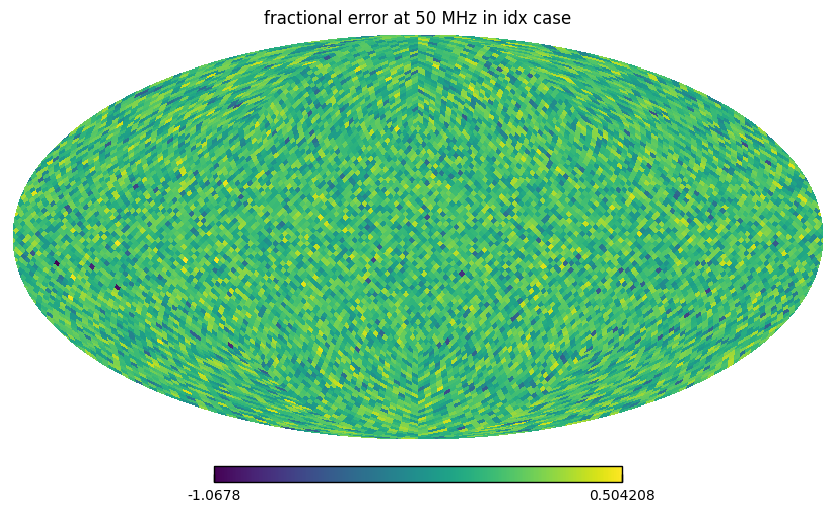

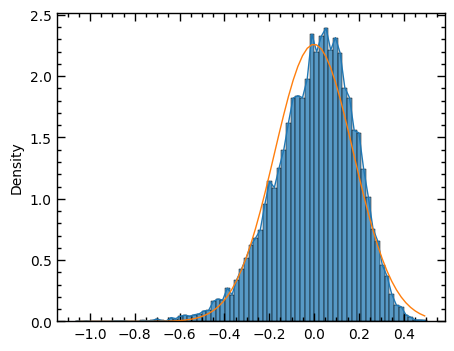

Gauss width = 0.17653117000638605
chi-sq = 520.1383176463848


In [27]:
# Contrast this with the prior index generation case.
_, idx_maps = SM.foreground_gsma_alm_nsidelo(nu=[50, 230, 408], lmax=32, nside=32, original_map=True, delta=SM.basemap_err_to_delta(5), err_type='idx', seed=124, meancorr=True)

hp.mollview((fid_maps[0]-idx_maps[0])/fid_maps[0], title="fractional error at 50 MHz in idx case")
plt.show()

# Fit the fractional errors with a gaussian to be sure.
n, bins = np.histogram((fid_maps[0]-idx_maps[0])/fid_maps[0], bins=75, density=True)
xx = [(bins[i]+bins[i+1])/2 for i in range(0,len(bins)-1)]
xx = np.array(xx)
f = lambda x,sig: 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*x**2/sig**2)
res = curve_fit(f, xx, n)

sns.histplot((fid_maps[0]-idx_maps[0])/fid_maps[0], bins=75, stat='density')
plt.plot(xx, n)
plt.plot(xx, f(xx, *res[0]))
plt.show()
print("Gauss width =", res[0][0])

# Calculate the chi-squared statistic of the fit.
chi_sq = np.sum((n-f(xx,*res[0]))**2/f(xx,*res[0]))
print("chi-sq =", chi_sq)

plt.show()

In [28]:
# Test the generation of different instances of bm2 foregrounds.
bm2_maps = []
for i in range(20):
    _, m = SM.foreground_gsma_alm_nsidelo(nu=np.linspace(50, 100, 51), lmax=32, nside=32, original_map=True, delta=SM.basemap_err_to_delta(5), err_type='idx', seed=223+i, meancorr=True)
    bm2_maps.append(m)
_, fid_map = SM.foreground_gsma_alm_nsidelo(nu=np.linspace(50, 100, 51), lmax=32, nside=32, original_map=True)


correcting for mean


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean
correcting for mean


In [29]:
np.shape(bm2_maps)
bm2_mean = np.mean(bm2_maps[:5], axis=0)
bm2_std  = np.std(bm2_maps[:5], axis=0)

bm2_mean_all = np.mean(bm2_maps, axis=0)
bm2_std_all  = np.std(bm2_maps, axis=0)

<Axes: ylabel='Count'>

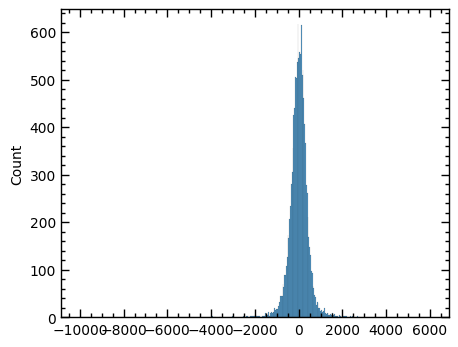

In [30]:
# Compare at 60 MHz.
sns.histplot(fid_map[10]-bm2_mean[10])

<Axes: ylabel='Count'>

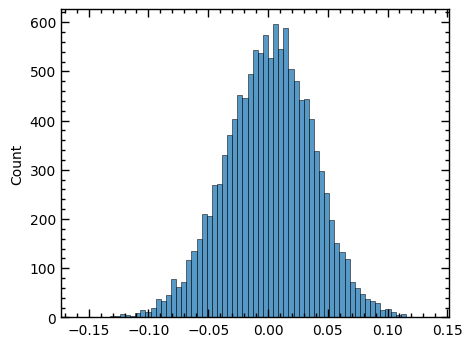

In [36]:
# Compare at 60 MHz.
sns.histplot((fid_map[10]-bm2_mean_all[10])/fid_map[10])

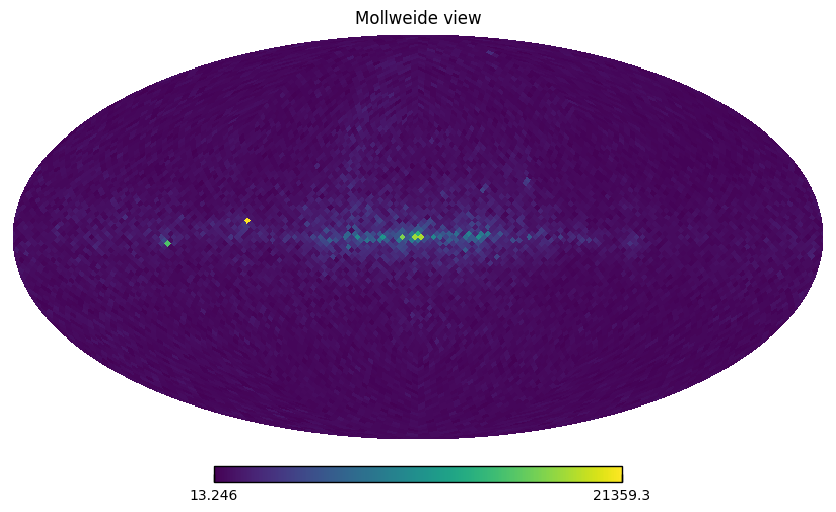

In [32]:
hp.mollview(bm2_std[10])

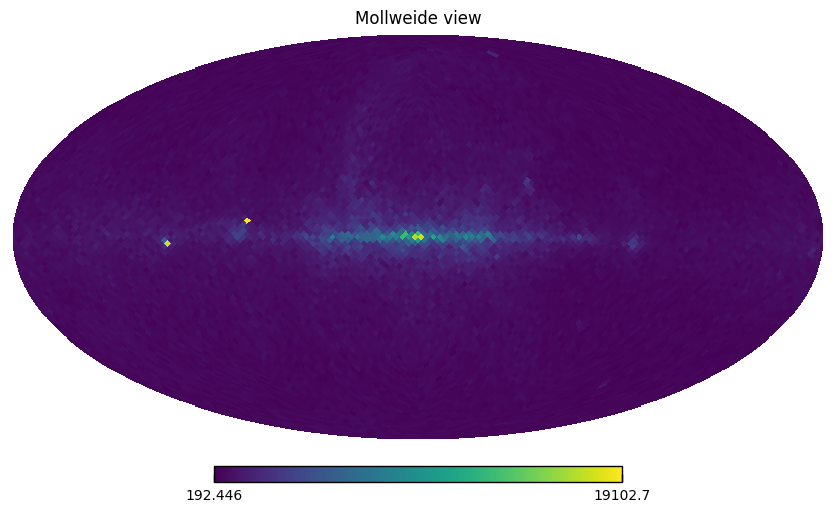

In [33]:
hp.mollview(bm2_std_all[10])


In [25]:
SM.basemap_err_to_delta(5)

0.08512072063579337

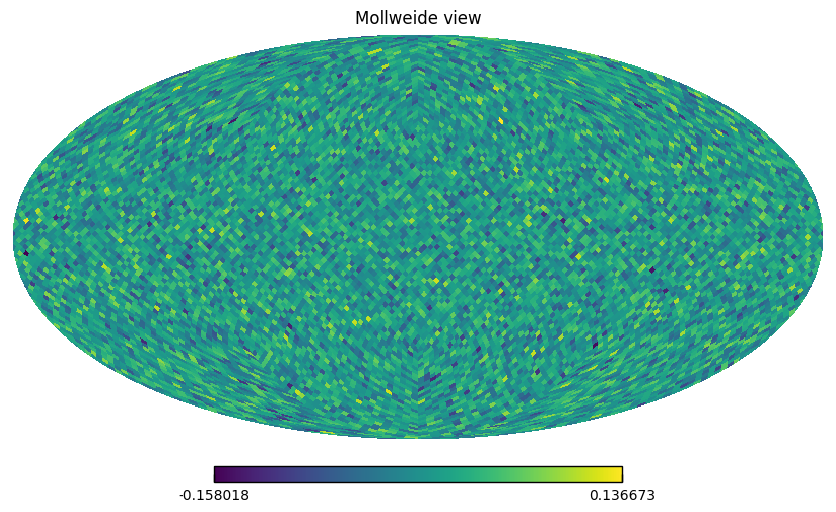

In [35]:
hp.mollview((fid_map[10]-bm2_mean_all[10])/fid_map[10])

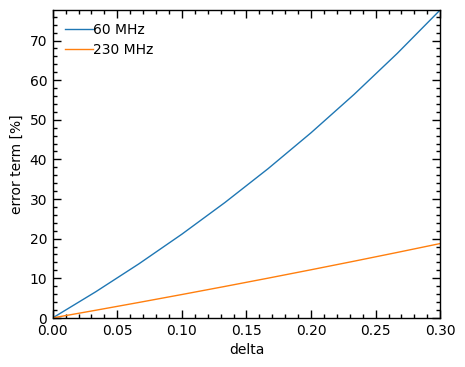

In [10]:
delta = np.linspace(0,0.3,10)
percentage_err_60  = (60/408)**(-delta) - 1
percentage_err_230 = (230/408)**(-delta) - 1
plt.plot(delta, 1e2*percentage_err_60, label='60 MHz')
plt.plot(delta, 1e2*percentage_err_230, label='230 MHz')
plt.xlabel("delta")
plt.ylabel("error term [%]")
plt.xlim(0,delta[-1])
plt.ylim(1e2*np.min([percentage_err_230[0],percentage_err_60[0]]),
         1e2*np.max([percentage_err_230[-1],percentage_err_60[-1]]))
plt.legend()
plt.show()


In [4]:
np.min?

Signature:
np.min(
    a,
    axis=None,
    out=None,
    keepdims=<no value>,
    initial=<no value>,
    where=<no value>,
)
Docstring:
Return the minimum of an array or minimum along an axis.

Parameters
----------
a : array_like
    Input data.
axis : None or int or tuple of ints, optional
    Axis or axes along which to operate.  By default, flattened input is
    used.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, the minimum is selected over multiple axes,
    instead of a single axis or all the axes as before.
out : ndarray, optional
    Alternative output array in which to place the result.  Must
    be of the same shape and buffer length as the expected output.
    See :ref:`ufuncs-output-type` for more details.

keepdims : bool, optional
    If this is set to True, the axes which are reduced are left
    in the result as dimensions with size one. With this option,
    the result will broadcast correctly against the input array.

    If the default value is p